# Visualizing and Analyzing BRFSS and LAUS merged Dataset - California
This notebook demonstrates visualization techniques and analytical techniques used in analyzing the BRFSS-Laus merged dataset as part of our report, as well as visualizations of an auxiliary dataset, Median Household Income data from SAIPE. This auxiliary dataset was chosen to help with drawing conclusions about the relationship between **unemployment shocks**, **income**, and **general health**.

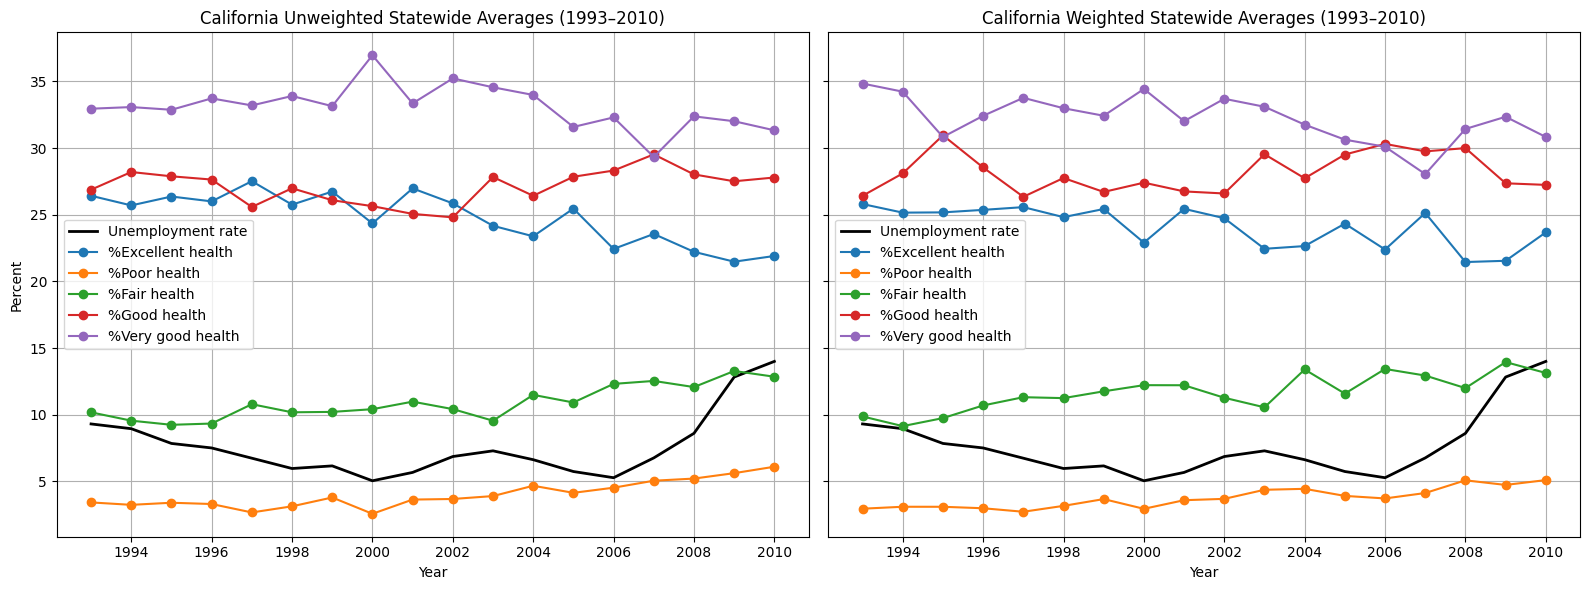

In [76]:
## Universal Module Imports
import re
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.animation as animation
import seaborn as sns
import folium
from branca.element import Element
from IPython.display import HTML
import statsmodels.api as sm

# Load merged dataset from 01_merge_LA_BRFSS_ca
df = pd.read_csv("california_health_bls_merged.csv")

# Drop non-numeric columns
X = df.drop(columns=["county_name", "survey_year"])

# BRFSS includes a core question on self-reported overall health and wellbeing. Proxy for overall health/wellbeing. The graph below also tests if you've properly set up the population-weighted fields.
trend_vars = {
    "general_health_status_Excellent_uw": "%Excellent health",
    "general_health_status_Poor_uw": "%Poor health",
    "general_health_status_Fair_uw" : "%Fair health",
    "general_health_status_Good_uw" : "%Good health",
    "general_health_status_Very good_uw" : "%Very good health"
}

trend_vars_w = {
    "general_health_status_Excellent_w": "%Excellent health",
    "general_health_status_Poor_w": "%Poor health",
    "general_health_status_Fair_w" : "%Fair health",
    "general_health_status_Good_w" : "%Good health",
    "general_health_status_Very good_w" : "%Very good health",
}

trend_uw = df.groupby("survey_year")[["unemployment_rate_mean"] + list(trend_vars.keys())].mean()
trend_w  = df.groupby("survey_year")[["unemployment_rate_mean"] + list(trend_vars_w.keys())].mean()

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# --- Unweighted plot ---
axes[0].plot(trend_uw.index, trend_uw["unemployment_rate_mean"],
             label="Unemployment rate", color="black", linewidth=2)

for col, label in trend_vars.items():
    axes[0].plot(trend_uw.index, trend_uw[col], marker="o", label=label)

axes[0].set_title("California Unweighted Statewide Averages (1993–2010)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Percent")
axes[0].grid(True)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].legend()

# --- Weighted plot ---
axes[1].plot(trend_w.index, trend_w["unemployment_rate_mean"],
             label="Unemployment rate", color="black", linewidth=2)

for col, label in trend_vars_w.items():
    axes[1].plot(trend_w.index, trend_w[col], marker="o", label=label)

axes[1].set_title("California Weighted Statewide Averages (1993–2010)")
axes[1].set_xlabel("Year")
axes[1].grid(True)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].legend()

plt.tight_layout()
plt.show()

In [77]:
# Running a basic OLS regression on our widely available health feature, to see if it predicts unemployment. Running weighted and unweighted to better reflect population-distribution.

import statsmodels.api as sm

# WEIGHTED delta coefficient of uenmployment_rate_mean == -0.486 r2 = 0.078
y = df["general_health_status_Excellent_w"]
X = df[["unemployment_rate_mean"]]  # predictors
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


# UNWEIGHTED delta coefficient of unemployment_rate_mean == -0.6588, r2 = 0.180
y = df["general_health_status_Excellent_uw"]
X = df[["unemployment_rate_mean"]]  # predictors
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     general_health_status_Excellent_w   R-squared:                       0.078
Model:                                           OLS   Adj. R-squared:                  0.077
Method:                                Least Squares   F-statistic:                     40.19
Date:                               Fri, 03 Oct 2025   Prob (F-statistic):           5.38e-10
Time:                                       18:35:13   Log-Likelihood:                -1587.2
No. Observations:                                474   AIC:                             3178.
Df Residuals:                                    472   BIC:                             3187.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                             coef    std err          t     

In [78]:
# Running a secondary regression; it seems the strongest effects come from using Excellent as the marker of health performance. 

import statsmodels.api as sm

# coefficient of uenmployment_rate_mean == 0.21~ r2 = 0.055
y = df["general_health_status_Poor_w"]
X = df[["unemployment_rate_mean"]]  # predictors
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


# coefficient of unemployment_rate_mean == 0.27~, r2 = 0.098
y = df["general_health_status_Poor_uw"]
X = df[["unemployment_rate_mean"]]  # predictors
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     general_health_status_Poor_w   R-squared:                       0.069
Model:                                      OLS   Adj. R-squared:                  0.067
Method:                           Least Squares   F-statistic:                     35.09
Date:                          Fri, 03 Oct 2025   Prob (F-statistic):           6.07e-09
Time:                                  18:35:13   Log-Likelihood:                -1214.1
No. Observations:                           474   AIC:                             2432.
Df Residuals:                               472   BIC:                             2441.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------

# Interpreting our Regressions - *What is the effect of Unemployment on Reported Excellent Health?*

We find a clear, statistically signifcant relationship within our dataset between unemployment rate and self-reported health. 

Our data range contains the 2008 Great Recession, which can be seen in the visualization above as the spike from 7% mean unemployment to around 14% mean unemployment. This change coincided with a substantial decrease in reports of "Excellent Health" on the BRFSS survey.

For California, the Excellent health coefficient moves more substantially when weighting, from -0.65 to -0.48. 

This reduction is larger in magnitude than the reduction for the Michigan survey, suggesting that Michigan and California's surveys have differences in the distribution of their raw sample.  The survey in California was more likely to overcount healthier individuals, shown by the larger magnitude of reduction, whereas the Michigan survey likely undercounted those individuals in Michigan's population.

Regardless, this also indicates there was a moderate effect of unemployment on health outcomes, both Excellent and Poor, within the population. 

### The true population effect of a one point increase in unemployment on Excellent health reporting was a decrease of 0.48 percentage points, when weighted for population.

### The true population effect of a one point increase in unemployment on Poor health reporting was an increase of 0.20 percentage points, when weighted for population.

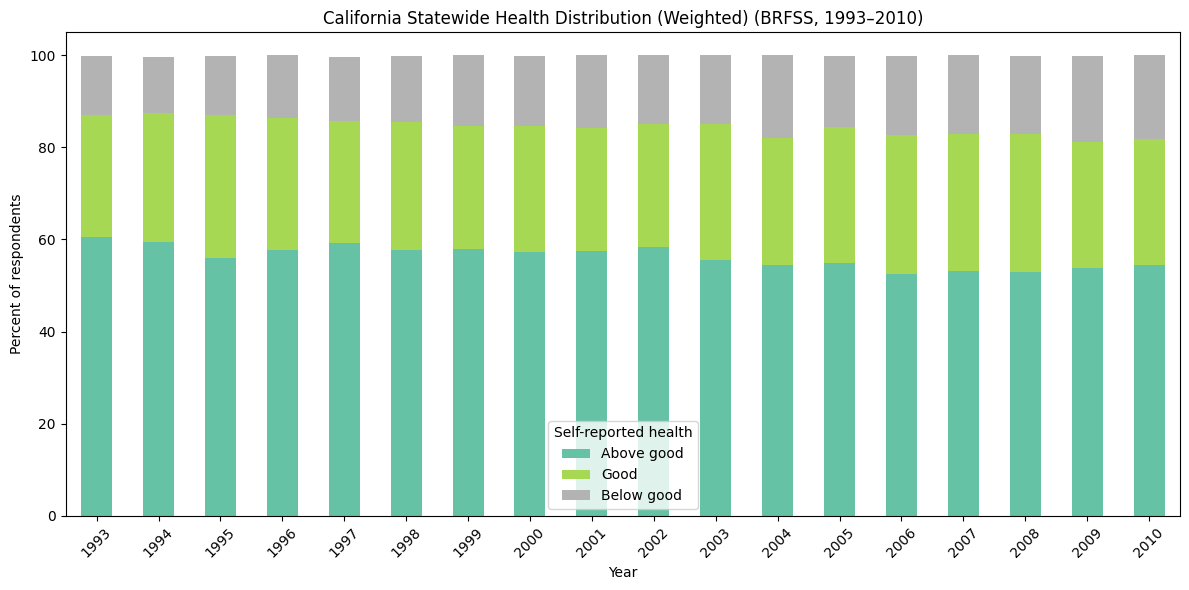

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute statewide averages
trend = df.groupby("survey_year")[list(trend_vars_w.keys())].mean()

# Collapse into 3 categories
trend["Above good"] = trend["general_health_status_Excellent_w"] + trend["general_health_status_Very good_w"]
trend["Good"]       = trend["general_health_status_Good_w"]
trend["Below good"] = trend["general_health_status_Fair_w"] + trend["general_health_status_Poor_w"]

# Keep only the collapsed categories
collapsed = trend[["Above good", "Good", "Below good"]]

# Plot as stacked bars over time
collapsed.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="Set2"
)

plt.title("California Statewide Health Distribution (Weighted) (BRFSS, 1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent of respondents")
plt.legend(title="Self-reported health")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


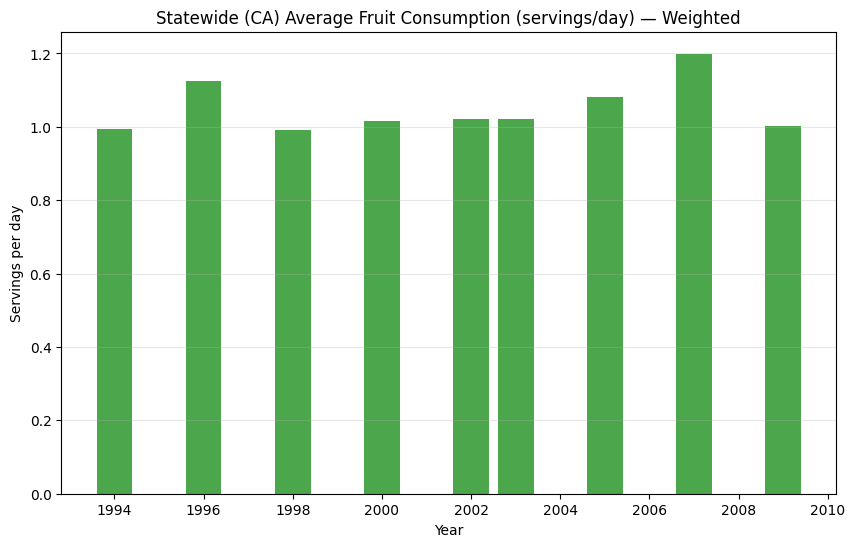

In [80]:

# 0) Choose weighted or unweighted
flavor = "_w"

# 1) grab all coded fruit-frequency columns for that flavor
#    eats_fruit_XXX_(w|uw) where XXX in 101–199 (day), 201–299 (week), 301–399 (month)
pat = re.compile(rf"^eats_fruit_(\d+)(?:\.0)?_{flavor[1:]}$")
fruit_cols = []
rates = {}

for c in df.columns:
    m = pat.match(c)
    if not m:
        continue
    code = int(m.group(1))
    # map BRFSS codes to daily rate
    if 101 <= code <= 199:      # times per day
        n = code - 100
        rate = float(n)
    elif 201 <= code <= 299:    # times per week
        n = code - 200
        rate = float(n) / 7.0
    elif 301 <= code <= 399:    # times per month
        n = code - 300
        rate = float(n) / 30.0
    else:
        # ignore non-frequency or special codes (1,2,7,9 etc)
        continue
    fruit_cols.append(c)
    rates[c] = rate

# 2) statewide yearly averages of *shares* in each bucket
shares = df.groupby("survey_year")[fruit_cols].mean(numeric_only=True)

# convert percents to proportions if needed
if shares.to_numpy().max() > 1.0:
    shares = shares / 100.0

# 3) expected servings/day = sum_buckets ( share_b * daily_rate_b )
rate_series = pd.Series(rates, dtype="float64")[fruit_cols]
expected_per_day = (shares * rate_series).sum(axis=1).replace(0, np.nan)

# 4) plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(expected_per_day.index, expected_per_day.values, color = 'green', alpha=0.7,)
title_flavor = "Weighted" if flavor == "_w" else "Unweighted"
ax.set_title(f"Statewide (CA) Average Fruit Consumption (servings/day) — {title_flavor}")
ax.set_xlabel("Year")
ax.set_ylabel("Servings per day")
ax.grid(axis="y", alpha=0.3)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


['any_alcohol_past_month_Yes_uw', 'any_alcohol_past_month_No_uw', 'any_alcohol_past_month_Dont know_uw', 'any_alcohol_past_month_Refused_uw', 'any_alcohol_past_month_Yes_w', 'any_alcohol_past_month_No_w', 'any_alcohol_past_month_Dont know_w', 'any_alcohol_past_month_Refused_w']


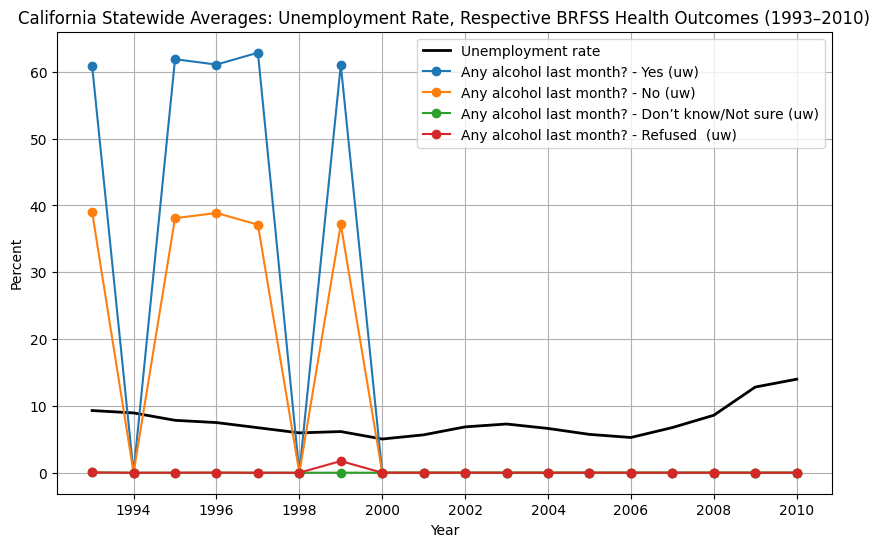

In [81]:
# Let's test some non-general_health_status variables in our merged dataset, such as alcohol consumption.
trend_vars_alc = {
    "any_alcohol_past_month_Yes_uw" : "Any alcohol last month? - Yes (uw)", 
    "any_alcohol_past_month_No_uw" : "Any alcohol last month? - No (uw)",
    "any_alcohol_past_month_Dont know_uw" : "Any alcohol last month? - Don’t know/Not sure (uw)", 
    "any_alcohol_past_month_Refused_uw" : "Any alcohol last month? - Refused  (uw)", \
}

# Compute statewide averages by year for each above
trend = df.groupby("survey_year")[["unemployment_rate_mean"] + list(trend_vars_alc.keys())].mean()

plt.figure(figsize=(10,6))

# Plot unemployment
plt.plot(trend.index, trend["unemployment_rate_mean"], label="Unemployment rate", color="black", linewidth=2)

# Plot health variables
for col, label in trend_vars_alc.items():
    plt.plot(trend.index, trend[col], marker="o", label=label)

plt.title("California Statewide Averages: Unemployment Rate, Respective BRFSS Health Outcomes (1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)


plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# Uh oh, major data quality issues; we don't have observations for most of our specified range of interest! 

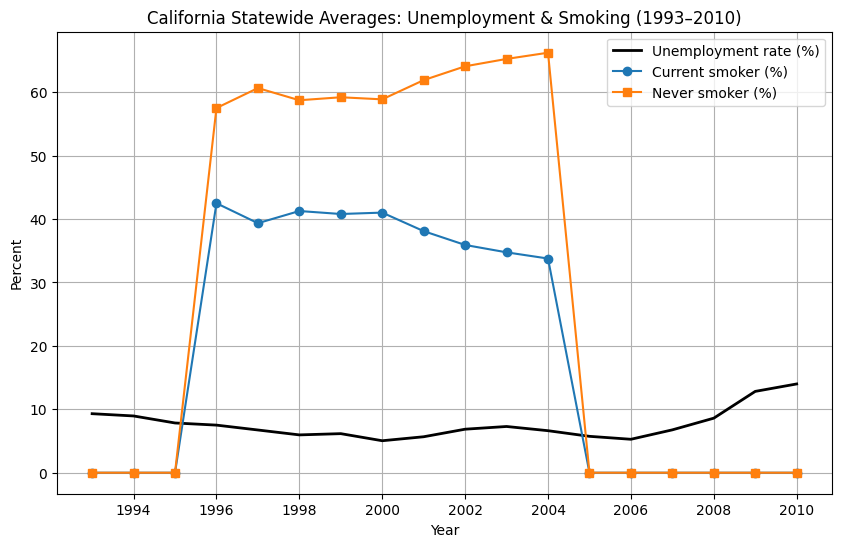

In [82]:
# Visualizing smoking survey range, as it has more coverage in California

# Collapse smoking categories into % current smoker
df["current_smoker"] = (
    df["current_smoking_frequency_Every day_uw"] +
    df["current_smoking_frequency_Some days_uw"]
)

df["never_smoker"] = df["current_smoking_frequency_Not at all_uw"]

# Compute statewide averages
trend_smoke = df.groupby("survey_year")[["current_smoker", "never_smoker"]].mean()
trend_unemp = df.groupby("survey_year")["unemployment_rate_mean"].mean()

# Merge into one DataFrame
trend = trend_smoke.join(trend_unemp)

plt.figure(figsize=(10,6))

# Unemployment in black (thick line)
plt.plot(trend.index, trend["unemployment_rate_mean"], 
         label="Unemployment rate (%)", color="black", linewidth=2)

# Smoking variables with markers
plt.plot(trend.index, trend["current_smoker"], marker="o", label="Current smoker (%)")
plt.plot(trend.index, trend["never_smoker"], marker="s", label="Never smoker (%)")

plt.title("California Statewide Averages: Unemployment & Smoking (1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()



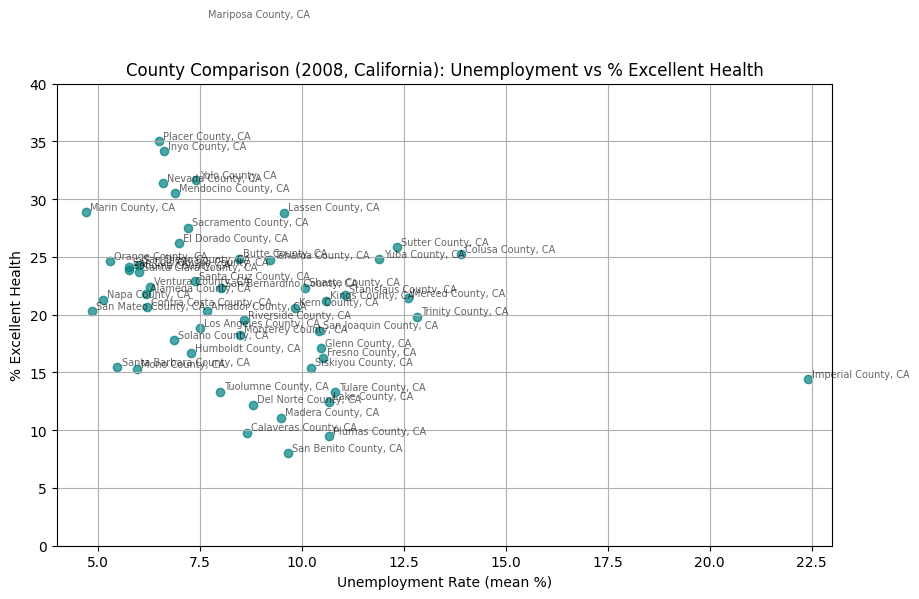

In [83]:
year = 2008  # you can change this to 2005, 2010, etc.
subset = df[df["survey_year"] == year]

plt.figure(figsize=(10,6))
plt.scatter(
    subset["unemployment_rate_mean"], 
    subset["general_health_status_Excellent_w"], 
    alpha=0.7, color="teal"
)

# Label counties
for i, row in subset.iterrows():
    plt.text(
        row["unemployment_rate_mean"]+0.1, 
        row["general_health_status_Excellent_w"]+0.2, 
        row["county_name"], fontsize=7, alpha=0.6
    )

plt.title(f"County Comparison ({year}, California): Unemployment vs % Excellent Health")
plt.xlim(4, 23)
plt.ylim(0,40)
plt.xlabel("Unemployment Rate (mean %)")
plt.ylabel("% Excellent Health")
plt.grid(True)
plt.show()

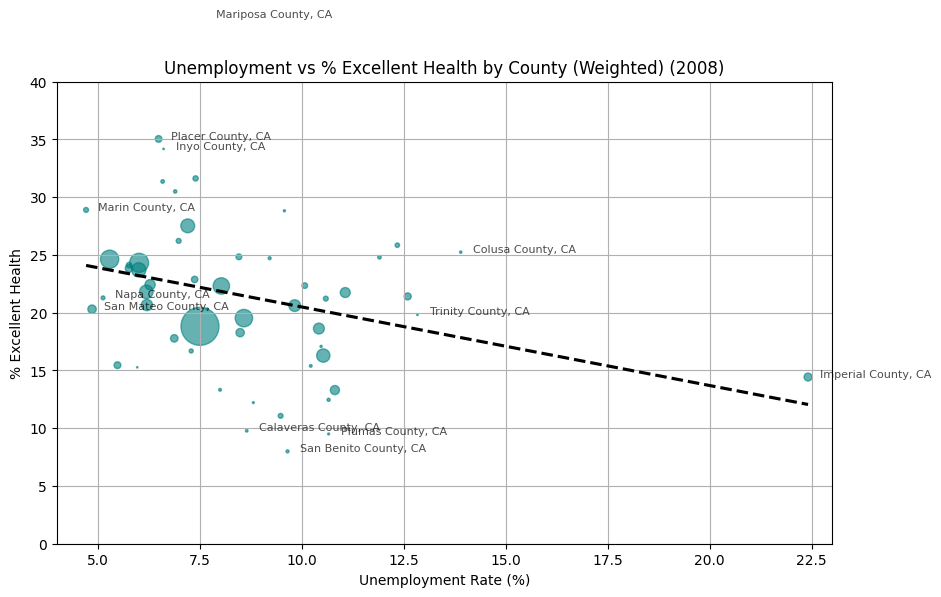

In [84]:
year = 2008
subset = df[df["survey_year"] == year].copy()

# If population data exists, use it. Otherwise, fake with labor force size as proxy
subset["pop_weight"] = subset["labor_force_mean"]  # proxy for population

plt.figure(figsize=(10,6))

# Scatter with population-scaled bubbles
sns.regplot(
    x="unemployment_rate_mean", 
    y="general_health_status_Excellent_w", 
    data=subset, scatter=False, color="black", ci=None, line_kws={"linestyle":"--"}
)

plt.scatter(
    subset["unemployment_rate_mean"], 
    subset["general_health_status_Excellent_w"], 
    s=subset["pop_weight"]/500,  # scale size
    alpha=0.6, color="teal"
)

# Label only extreme counties (top/bottom 3 unemployment and health)
top_unemp = subset.nlargest(3, "unemployment_rate_mean")
low_unemp = subset.nsmallest(3, "unemployment_rate_mean")
top_health = subset.nlargest(3, "general_health_status_Excellent_w")
low_health = subset.nsmallest(3, "general_health_status_Excellent_w")

highlight = pd.concat([top_unemp, low_unemp, top_health, low_health]).drop_duplicates()

for i, row in highlight.iterrows():
    plt.text(row["unemployment_rate_mean"]+0.3,
             row["general_health_status_Excellent_w"],
             row["county_name"], fontsize=8, alpha=0.7)

plt.title(f"Unemployment vs % Excellent Health by County (Weighted) ({year})")
plt.xlabel("Unemployment Rate (%)")
plt.xlim(4, 23)
plt.ylim(0,40)
plt.ylabel("% Excellent Health")
plt.grid(True)
plt.show()

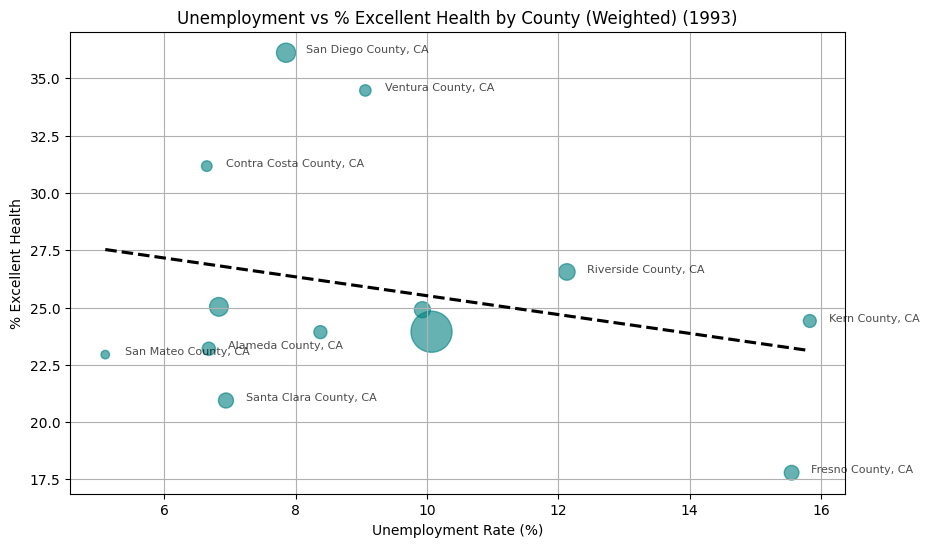

In [85]:
years = sorted(df["survey_year"].unique())

fig, ax = plt.subplots(figsize=(10,6))

def update(year):
    ax.clear()
    subset = df[df["survey_year"] == year].copy()
    subset["pop_weight"] = subset["labor_force_mean"]

    # Regression line
    sns.regplot(
        x="unemployment_rate_mean", 
        y="general_health_status_Excellent_w", 
        data=subset, scatter=False, color="black", ci=None, 
        line_kws={"linestyle":"--"}, ax=ax
    )

    # Bubbles
    ax.scatter(
        subset["unemployment_rate_mean"], 
        subset["general_health_status_Excellent_w"], 
        s=subset["pop_weight"]/500, alpha=0.6, color="teal"
    )

    # Label extreme counties
    top_unemp = subset.nlargest(3, "unemployment_rate_mean")
    low_unemp = subset.nsmallest(3, "unemployment_rate_mean")
    top_health = subset.nlargest(3, "general_health_status_Excellent_w")
    low_health = subset.nsmallest(3, "general_health_status_Excellent_w")
    highlight = pd.concat([top_unemp, low_unemp, top_health, low_health]).drop_duplicates()

    for _, row in highlight.iterrows():
        ax.text(row["unemployment_rate_mean"]+0.3,
                row["general_health_status_Excellent_w"],
                row["county_name"], fontsize=8, alpha=0.7)

    ax.set_title(f"Unemployment vs % Excellent Health by County (Weighted) ({year})")
    ax.set_xlabel("Unemployment Rate (%)")
    ax.set_ylabel("% Excellent Health")
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=years, interval=1000, repeat=True)

# Render inline as HTML5 animation
HTML(ani.to_jshtml())

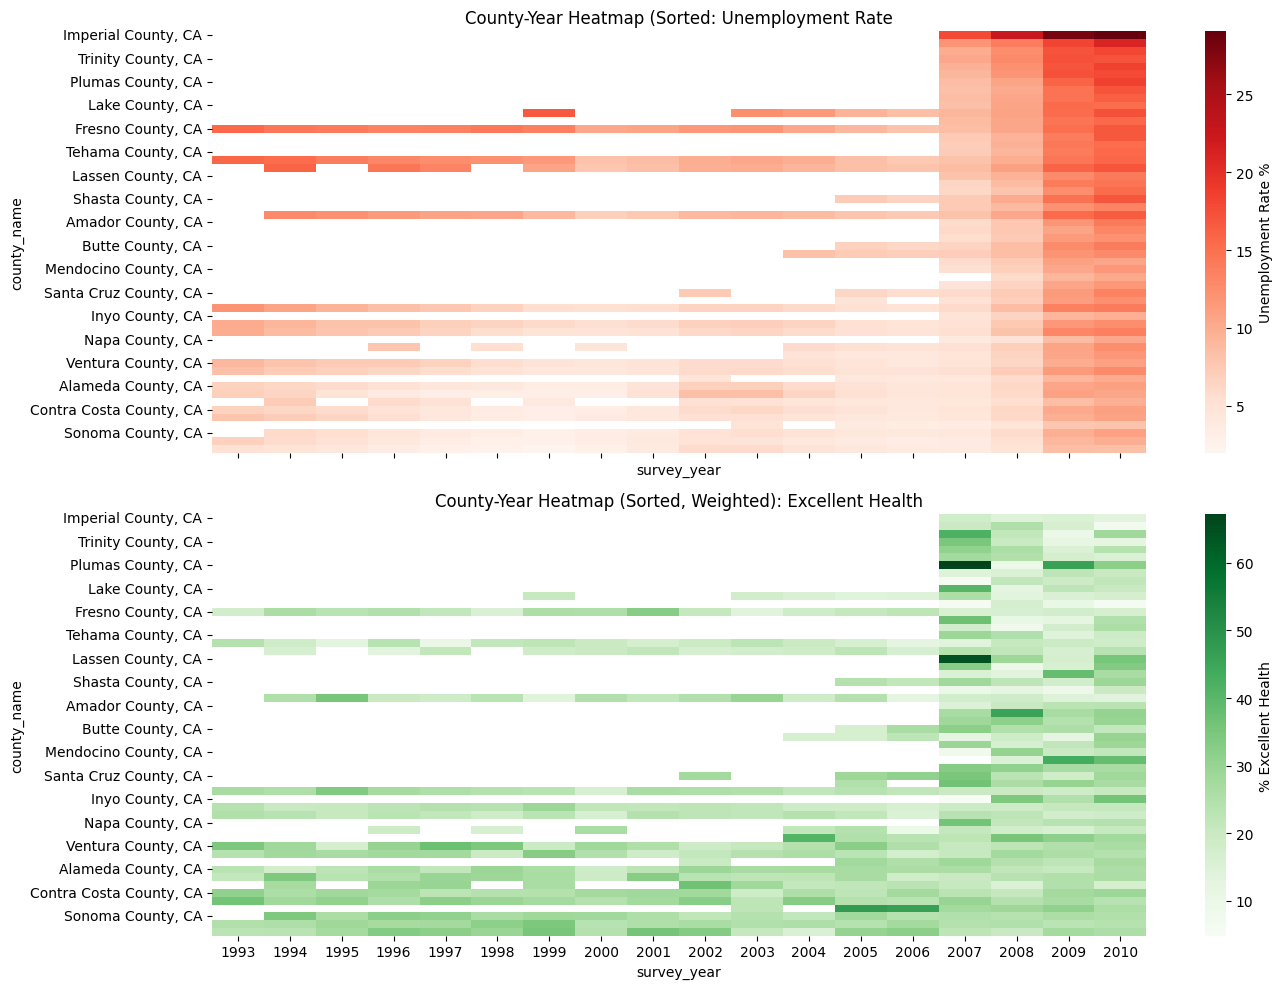

In [86]:
# Compute average unemployment across years per county
county_order = (
    df.groupby("county_name")["unemployment_rate_mean"]
    .mean()
    .sort_values(ascending=False)  # highest unemployment at top
    .index
)

# Pivot tables for unemployment & health
unemp_pivot = df.pivot_table(
    index="county_name", columns="survey_year", values="unemployment_rate_mean"
).loc[county_order]

health_pivot = df.pivot_table(
    index="county_name", columns="survey_year", values="general_health_status_Excellent_w"
).loc[county_order]

# Plot side-by-side heatmaps
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.heatmap(unemp_pivot, cmap="Reds", ax=axes[0], cbar_kws={'label': 'Unemployment Rate %'})
axes[0].set_title("County-Year Heatmap (Sorted: Unemployment Rate")

sns.heatmap(health_pivot, cmap="Greens", ax=axes[1], cbar_kws={'label': '% Excellent Health'})
axes[1].set_title("County-Year Heatmap (Sorted, Weighted): Excellent Health")

plt.tight_layout()
plt.show()

## Data Coverage

California has better data coverage than Michigan, as shown by the Seaborn heatmap showing coverage of observed health during years. This was part of why it was chosen for this dual-analysis. 

## Bivariate Chloropleth

We constructed a bivariate choropleth to visualize the intersection of two dimensions at the county level: economic stress (unemployment) and self-reported health outcomes.

A univariate map of either unemployment or health alone was tested, but it would miss the interaction between the two — some counties may have high unemployment but relatively resilient health outcomes, while others may show sharp declines in health with only modest labor market shocks.

By combining both indicators in a single bivariate color scale, the map allows us to quickly identify “hotspots” where economic downturns most strongly coincide with poor health reporting, and to compare regions that are red (both poor unemployment and poor excellent health rating) with regions from the SAIPE county median income database. 

This visualization is particularly important in the context of the 2008 Great Recession, when both unemployment and adverse health outcomes spiked across many counties.

- Counties that are colored black do not have a valid BRFSS survey for that year to link to unemployment statistics. 

In [92]:
# Pick a year
year = 2010
subset = df[df["survey_year"] == year].copy()

# Clean county names to match GeoJSON property "name"
subset["county_clean"] = subset["county_name"].str.replace(" County, CA", "", regex=False)

# Load California GeoJSON as dict from Github
geo = requests.get(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
).json()

# Choose cutoffs (use medians by default)
u_cut = subset["unemployment_rate_mean"].median()
h_cut = subset["general_health_status_Excellent_w"].median()

# Create bins
subset["u_bin2"] = (subset["unemployment_rate_mean"] > u_cut).astype(int)
subset["h_bin2"] = (subset["general_health_status_Excellent_w"] <= h_cut).astype(int)

# Quadrant labels
quad_labels = {
    (0,0): "Low unemployment + High % Excellent Health",
    (0,1): "High unemployment + High % Excellent Health",
    (1,0): "Low unemployment + Low % Excellent Health",
    (1,1): "High unemployment + Low % Excellent Health",
}
subset["quadrant"] = subset.apply(
    lambda r: quad_labels[(int(r["h_bin2"]), int(r["u_bin2"]))], axis=1
)

# Quadrant colors
bivar2_colors = {
    (0,0): "#2ca25f",  # green
    (0,1): "#1f9fb5",  # teal
    (1,0): "#fdae61",  # amber
    (1,1): "#d73027",  # red
}
subset["bivar2_color"] = subset.apply(
    lambda r: bivar2_colors[(int(r["h_bin2"]), int(r["u_bin2"]))], axis=1
)

# Build lookup dict
lookup = subset.set_index("county_clean")[
    ["bivar2_color", "quadrant", "unemployment_rate_mean", "general_health_status_Excellent_w"]
].rename(columns={
    "bivar2_color": "bivar2",
    "unemployment_rate_mean": "unemp_pct",
    "general_health_status_Excellent_w": "excellent_pct"
}).to_dict(orient="index")

# Merge into GeoJSON
for feat in geo["features"]:
    name = feat["properties"]["name"]  # CA GeoJSON uses "name"
    rec = lookup.get(name)
    if rec:
        feat["properties"].update({
            "bivar2": rec["bivar2"],
            "quadrant": rec["quadrant"],
            "unemp_pct": round(rec["unemp_pct"], 1),
            "excellent_pct": round(rec["excellent_pct"], 1),
        })
    else:
        feat["properties"].update({
            "bivar2": "#000000",
            "quadrant": "No data",
            "unemp_pct": None,
            "excellent_pct": None,
        })

# Build map
m_CA_Bivariate = folium.Map(location=[37.5, -119.5], zoom_start=6)

folium.GeoJson(
    geo,
    style_function=lambda f: {
        "fillColor": f["properties"]["bivar2"],
        "color": "white",
        "weight": 0.6,
        "fillOpacity": 0.9
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "unemp_pct", "excellent_pct", "quadrant"],
        aliases=["County:", "Unemployment (%):", "% Excellent Health:", "Category:"],
        localize=True,
        sticky=False
    )
).add_to(m_CA_Bivariate)

# Legend
legend_html = f"""
<style>
  .bivar2-card {{
    position: fixed; bottom: 20px; left: 20px;
    background: #fff; border: 1px solid #555; border-radius: 6px;
    padding: 8px; font: 11px/1.3 Arial, sans-serif; color: #222;
    z-index: 9999; box-shadow: 0 2px 4px rgba(0,0,0,.25);
    pointer-events: none; display: inline-block;
  }}
  .title {{ font-weight: 700; margin-bottom: 4px; font-size: 12px; }}
  .grid {{ display: grid; grid-template-columns: repeat(2, 140px); gap: 3px; }}
  .cell {{ display:flex; align-items:center; gap:4px; padding:3px;
           border:1px solid #ccc; border-radius:3px; font-size:10px; }}
  .swatch {{ width:10px; height:10px; border:1px solid #666; }}
  .note {{ margin-top:4px; font-size:9px; color:#444; }}
</style>

<div class="bivar2-card">
  <div class="title">Bivariate Legend</div>
  <div class="grid">
    <div class="cell"><div class="swatch" style="background:#2ca25f"></div>
      Low unemp + High health
    </div>
    <div class="cell"><div class="swatch" style="background:#1f9fb5"></div>
      High unemp + High health
    </div>
    <div class="cell"><div class="swatch" style="background:#fdae61"></div>
      Low unemp + Low health
    </div>
    <div class="cell"><div class="swatch" style="background:#d73027"></div>
      High unemp + Low health
    </div>
  </div>
  <div class="note">
    Cutoffs — Unemp: <b>{u_cut:.1f}%</b>; Health: <b>{h_cut:.1f}%</b><br>
    Black = missing/no match
  </div>
</div>
"""

m_CA_Bivariate.get_root().html.add_child(Element(legend_html))

m_CA_Bivariate


In [93]:
# -----------------------------
# 0) CONFIG (California + SAIPE year)
# -----------------------------
STATE_NAME = "California"
STATE_ABBR = "CA"
STATE_FIPS = "06"

state_cfg = {
    "fips": STATE_FIPS,
    "geo_path": "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson",
    "geo_is_url": True,
    "name_props_candidates": ["name", "Name", "NAME", "Label", "label"],
    "map_center": [37.25, -119.6],
    "zoom": 6,
}

SAIPE_YEAR = 2010   # <-- pick any year 1993+

# -----------------------------
# Helper: state-aware name normalizer
# -----------------------------
def normalize_name(s: str, state_name=STATE_NAME, state_abbr=STATE_ABBR) -> str:
    if pd.isna(s): return ""
    s = str(s).lower().replace("&", " and ")
    s = re.sub(fr",\s*{re.escape(state_name.lower())}$", "", s)
    s = re.sub(fr",\s*{re.escape(state_abbr.lower())}$", "", s)
    s = re.sub(r"\bcity and county of\b", "", s)
    s = re.sub(r"\bcounty\b", "", s)
    s = re.sub(r"\bst[\.]?\b", "saint", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

# -----------------------------
# 1) Pull SAIPE median HH income for CA counties (SAEMHI_PT)
# -----------------------------
def fetch_saipe_income_ca(year: int) -> pd.DataFrame:
    url = "https://api.census.gov/data/timeseries/poverty/saipe"
    params = {
        "get": "NAME,SAEMHI_PT",
        "time": str(year),
        "for": "county:*",
        "in": f"state:{STATE_FIPS}",
    }
    r = requests.get(url, params=params, timeout=60)
    if r.status_code == 204:
        return pd.DataFrame(columns=["county_fips","county_name_full","county_key","median_income"])
    r.raise_for_status()
    cols, rows = r.json()[0], r.json()[1:]
    df = pd.DataFrame(rows, columns=cols)
    df.rename(columns={"SAEMHI_PT": "median_income"}, inplace=True)
    df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")
    df["county_name_full"] = df["NAME"]
    df["county_key"] = df["county_name_full"].apply(normalize_name)
    df["state"] = df["state"].astype(str).str.zfill(2)
    df["county"] = df["county"].astype(str).str.zfill(3)
    df["county_fips"] = df["state"] + df["county"]
    return df[["county_fips","county_name_full","county_key","median_income"]]

income_df = fetch_saipe_income_ca(SAIPE_YEAR)

# -----------------------------
# 2) Load CA GeoJSON and add normalized key
# -----------------------------
if state_cfg["geo_is_url"]:
    geo = requests.get(state_cfg["geo_path"], timeout=60).json()
else:
    with open(state_cfg["geo_path"], "r") as f:
        geo = json.load(f)

props0 = geo["features"][0]["properties"]
name_prop = next((p for p in state_cfg["name_props_candidates"] if p in props0), None)
if name_prop is None:
    raise ValueError(
        f"No expected name property found in GeoJSON. Tried: {state_cfg['name_props_candidates']}."
    )

for feat in geo["features"]:
    raw = feat["properties"].get(name_prop, "")
    feat["properties"]["_key"] = normalize_name(raw)

# -----------------------------
# 3) Tertiles + color map
# -----------------------------
income_df = income_df[pd.notna(income_df["median_income"])].copy()
if income_df["median_income"].nunique() >= 3:
    income_df["income_bracket"] = pd.qcut(income_df["median_income"], q=3,
                                          labels=["Low","Middle","High"])
else:
    income_df["income_bracket"] = pd.cut(income_df["median_income"], bins=3,
                                         labels=["Low","Middle","High"], include_lowest=True)

color_map = {"Low": "#d73027", "Middle": "#fee08b", "High": "#1a9850"}

# -----------------------------
# 4) Join into GeoJSON
# -----------------------------
lookup = income_df.set_index("county_key")[["median_income","income_bracket"]]
matched = 0
for feat in geo["features"]:
    key = feat["properties"]["_key"]
    rec = lookup.loc[key] if key in lookup.index else None
    if rec is not None and pd.notna(rec["median_income"]):
        mhi = int(rec["median_income"])
        feat["properties"].update({
            "mhi": mhi,
            "mhi_fmt": f"${mhi:,.0f}",
            "mhi_bracket": str(rec["income_bracket"]),
            "fill_col": color_map[str(rec["income_bracket"])],
        })
        matched += 1
    else:
        feat["properties"].update({
            "mhi": None,
            "mhi_fmt": "No data",
            "mhi_bracket": "No data",
            "fill_col": "#000000",
        })
print(f"[INFO] Matched counties: {matched} / {len(geo['features'])} (SAIPE {SAIPE_YEAR})")

# -----------------------------
# 5) Map + legend (SAIPE)
# -----------------------------
m_SAIPE = folium.Map(location=state_cfg["map_center"], zoom_start=state_cfg["zoom"])

folium.GeoJson(
    geo,
    style_function=lambda f: {
        "fillColor": f["properties"]["fill_col"],
        "color": "white",
        "weight": 0.6,
        "fillOpacity": 0.9,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=[name_prop, "mhi_fmt", "mhi_bracket"],
        aliases=["County:", f"Median HH Income (SAIPE {SAIPE_YEAR}):", "Bracket:"],
        localize=True, sticky=False,
    ),
    name=f"SAIPE {SAIPE_YEAR} MHI (tertiles)"
).add_to(m_SAIPE)

statewide_median = income_df["median_income"].median()
statewide_median_fmt = f"${statewide_median:,.0f}"

legend_html = f"""
<style>
  .mhi-card {{
    position: fixed; bottom: 20px; left: 20px;
    background: #fff; border: 1px solid #555; border-radius: 6px;
    padding: 8px 10px; font: 11px/1.3 Arial, sans-serif; color: #222;
    z-index: 9999; box-shadow: 0 2px 4px rgba(0,0,0,.25);
    pointer-events: none; display: inline-block;
  }}
  .title {{ font-weight: 700; margin-bottom: 4px; font-size: 12px; }}
  .row {{ display:flex; align-items:center; gap:4px; margin: 2px 0; }}
  .swatch {{ width:10px; height:10px; border:1px solid #333; }}
  .note {{ margin-top:4px; font-size:9px; color:#444; }}
</style>
<div class="mhi-card">
  <div class="title">Median Household Income – SAIPE {SAIPE_YEAR}</div>
  <div class="row"><div class="swatch" style="background:#1a9850;"></div> High (top third)</div>
  <div class="row"><div class="swatch" style="background:#fee08b;"></div> Middle (middle third)</div>
  <div class="row"><div class="swatch" style="background:#d73027;"></div> Low (bottom third)</div>
  <div class="row" style="margin-top:4px; font-size:10px; font-weight:600;">
    Statewide Median: {statewide_median_fmt}
  </div>
  <div class="note">Black = missing/no match.</div>
</div>
"""

m_SAIPE.get_root().html.add_child(Element(legend_html))

m_SAIPE


[INFO] Matched counties: 58 / 58 (SAIPE 2010)


## Relationship between Bivariate Chloropleth and Median Household Income
After analyzing the county-level data, we decided to bring in a seperate data set to bring context to our somewhat skewed BRFSS and LAUS data.

 We also ran a basic similarity test between the two maps below : how many counties in the map match? How many counties are either in 

In [94]:
map1_html = m_CA_Bivariate._repr_html_()
map2_html = m_SAIPE._repr_html_()

html = f"""
<div style="display: flex; justify-content: space-around;">
    <div style="width: 48%;">{map1_html}</div>
    <div style="width: 48%;">{map2_html}</div>
</div>
"""

display(HTML(html))


In [96]:
# -------- Parameters --------
flavor = "_w"   # or "_uw"
health_var = f"general_health_status_Excellent{flavor}"

# -------- Helper: build bivariate labels for a given year --------
def build_bivariate_for_year(df, year, health_var):
    subset = df[df["survey_year"] == year].copy()
    # Clean county names to match your MI GeoJSON naming convention
    subset["county_clean"] = subset["county_name"].str.replace(", MI", "", regex=False)
    # Cutoffs
    u_cut = subset["unemployment_rate_mean"].median()
    h_cut = subset[health_var].median()
    # Bins (note: lower 'Excellent' = worse)
    subset["u_bin2"] = (subset["unemployment_rate_mean"] > u_cut).astype(int)
    subset["h_bin2"] = (subset[health_var] <= h_cut).astype(int)
    quad_labels = {
        (0,0): "Low unemployment + High % Excellent Health",
        (0,1): "High unemployment + High % Excellent Health",
        (1,0): "Low unemployment + Low % Excellent Health",
        (1,1): "High unemployment + Low % Excellent Health",
    }
    subset["quadrant"] = subset.apply(
        lambda r: quad_labels[(int(r["h_bin2"]), int(r["u_bin2"]))], axis=1
    )
    # Normalize key
    bivar_df = subset[["county_clean","quadrant"]].copy()
    bivar_df["county_key"] = bivar_df["county_clean"].apply(normalize_name)
    bivar_df = bivar_df.drop_duplicates(subset=["county_key"])
    return bivar_df, u_cut, h_cut

# -------- Helper: build income tertiles for a given year --------
def build_income_for_year(year):
    income_df = fetch_saipe_income_ca(year).copy()
    income_df = income_df[pd.notna(income_df["median_income"])]
    if income_df["median_income"].nunique() >= 3:
        income_df["income_bracket"] = pd.qcut(
            income_df["median_income"], q=3, labels=["Low","Middle","High"]
        )
    else:
        income_df["income_bracket"] = pd.cut(
            income_df["median_income"], bins=3, labels=["Low","Middle","High"], include_lowest=True
        )
    inc_df = income_df[["county_key","income_bracket"]].dropna()
    return inc_df

# -------- Alignment classification (your rules, with middle split) --------
good_bivar = "Low unemployment + High % Excellent Health"
poor_bivar = "High unemployment + Low % Excellent Health"
mid_good = "High unemployment + High % Excellent Health"   # teal
mid_poor = "Low unemployment + Low % Excellent Health"     # yellow

def classify_alignment(row):
    if row["income_bracket"] == "High" and row["bivar_class"] == good_bivar:
        return "Green ↔ Green"
    elif row["income_bracket"] == "Low" and row["bivar_class"] == poor_bivar:
        return "Red ↔ Red"
    elif row["income_bracket"] == "Middle" and row["bivar_class"] == mid_good:
        return "Middle ↔ Teal"
    elif row["income_bracket"] == "Middle" and row["bivar_class"] == mid_poor:
        return "Middle ↔ Yellow"
    else:
        return "Mismatch"

# -------- Years to run (survey >= 2005, SAIPE available through 2010) --------
years_df = sorted(int(y) for y in pd.unique(df["survey_year"]) if pd.notna(y))
survey_supported = {y for y in years_df if 2005 <= y <= 2010}  # your survey starts 2005
saipe_supported   = set(range(2005, 2011))                      # SAIPE 2005–2010 inclusive
years = sorted(survey_supported & saipe_supported)
all_summaries = []

for year in years:
    # Build both sides
    bivar_df, u_cut, h_cut = build_bivariate_for_year(df, year, health_var)
    inc_df = build_income_for_year(year)

    # Sanity checks
    if bivar_df.empty:
        print(f"[WARN] No bivariate rows for {year} (survey side). Skipping.")
        continue
    if inc_df.empty:
        print(f"[WARN] No SAIPE rows for {year}. Skipping.")
        continue

    # Merge to get comp
    comp = (
        bivar_df.merge(inc_df, on="county_key", how="inner")
                .rename(columns={"quadrant": "bivar_class"})
    )
    if comp.empty:
        print(f"[WARN] No county matches for {year}. Check name normalization.")
        continue

    # Classify alignment
    comp["simple_alignment"] = comp.apply(classify_alignment, axis=1)

    # Summarize
    counts = comp["simple_alignment"].value_counts()
    perc = (counts / counts.sum() * 100).round(1)

    # Store long/tidy rows
    for label, cnt in counts.items():
        all_summaries.append({
            "year": year,
            "alignment": label,
            "Count": int(cnt),
            "Percent": float(perc[label])
        })

alignment_long = pd.DataFrame(all_summaries).sort_values(["year", "alignment"])
alignment_wide = alignment_long.pivot(index="year", columns="alignment", values="Percent").fillna(0).round(1)

display(alignment_wide)

alignment,Green ↔ Green,Middle ↔ Teal,Middle ↔ Yellow,Mismatch,Red ↔ Red
year,,,,,
2005,25.9,7.4,7.4,48.1,11.1
2006,38.5,0.0,3.8,50.0,7.7
2007,17.0,7.5,9.4,54.7,11.3
2008,20.4,9.3,7.4,46.3,16.7
2009,24.1,1.9,0.0,55.6,18.5
2010,24.1,5.6,3.7,48.1,18.5
